# Unpack Hub Clustering
#### Developed by Job de Vogel, Lisa-Marie Mueller and Jirri van den Bos

In [1]:
# Inport the package developed by UNPACK
import unpack
# from unpack.utils.multicore_shortest_path import multicore_single_source_shortest_path, paths_to_dataframe, closest_hub
# from unpack.utils.multiplot import format_paths_for_plot, multiplot_save

import random

In [2]:
## Initialize variables
name = 'Delft_center_walk'
data_folder = 'data/'
vehicle_type = 'walk' # walk, bike, drive, all (See osmnx documentation)
coordinates = [52.018347, 52.005217, 4.369142, 4.350504]

## GENERATE NETWORK
Generate a new network using the functions in the CityNetwork class. If a network already has been generated and stored in the data folder, 
please continue with 'Prepare Network'!

In [3]:
# Initialize CityNetwork object [N, S, E, W]
City = unpack.CityNetwork(name, coordinates, vehicle_type)

In [6]:
# Load osm from local or online file
City.load_osm_graph(data_folder + name + '.osm')
City.load_building_addr(data_folder + name + '_building_addresses.csv', 
    data_folder + name + '_buildings.csv', 
    data_folder + name + '_addresses.csv',
    data_folder +'runtime/'+ name + '_cbs.xml')

print('Loading finished.')

Loading street network...
Finished loading
Loading buildings...
Finished adding EPSG:3857 coordinates
Assigning buildings to CBS buurt
Checking if a building is inside a buurt
2183 / 2183
Adding the CBS data to the dataframe
2183 / 2183
Loading finished.


In [7]:
# Add speeds, lengths and distances to graph
# Overwrite speed by using overwrite_bike=16
# Further types available: overwrite_walk and overwrite_epv
City.add_rel_attributes(overwrite_bike=16, overwrite_walk=5)

In [8]:
# Project graph to the correct coordinate system
City.project_graph()

In [12]:
# (Optional) assign an 'experience' weight to the graph
# Experience can be added based on street names or coordinates
latitude = 52.005831
longitude = 4.371026

City.add_street_experience(['Oude Delft'], [10])
# City.add_coord_experience([(latitude, longitude)], [10])

In [13]:
# Calculate dataframes of nodes and edges
City.convert_graph_edges_to_df()
City.convert_graph_nodes_to_df()

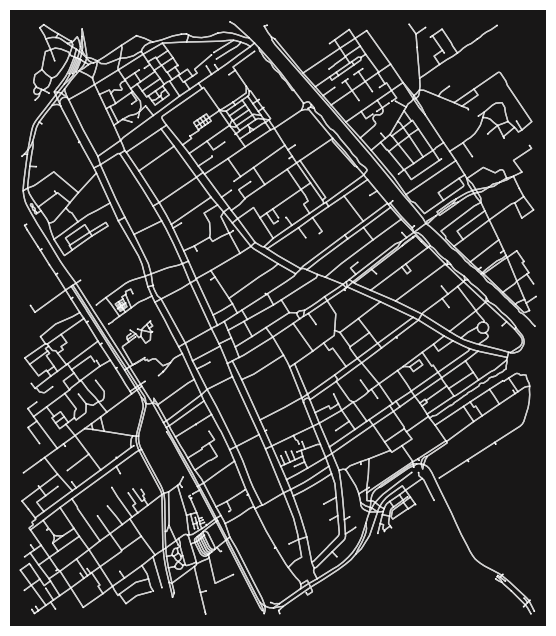

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [15]:
# (Optional) Plot the network
City.plot(show=True)

In [16]:
# (Optional) Save Pickle file of CityNetwork object
City.save_graph(name, data_folder)

Saving Delft_center_walk to data/Delft_center_walk.pkl


## Prepare Network
Load the CityNetwork object if it already has been initialized in a .pkl file.

In [3]:
# Load the CityNetwork
City = unpack.CityNetwork.load_graph(name, data_folder)

Loading...
Loaded Delft_center_walk to object...


## Compute Nearest Edges
To be able to compute shortest paths and clusters in the network, the nearest edges in the graph for each house have to be known. Therefore a multicore nearest edge algorithm has been developed.

Computing nearest edges may have a considerable computation time. Therefore it is recommended to run the computation once, and save the class object as a .pkl file again afterwards.

Approximate computation times:
* Full Delft: 15 minutes
* Delft city center: several minutes

In [4]:
# Compute nearest edges
# Run only once!
cpus = 12 # Indicate number of cores in your device

City.ne = None
City.nearest_edges(5, cpus=cpus)
City.save_graph(name, data_folder)

Interpolating MultiDiGraph with 1257 nodes and 3468 edges for finding nearest edges...
Finished interpolating in 2.78s...
Finding 2183 nearest edges with 12 CPUs...
USER-WARNING: Make sure you put the multicore_nearest_edge function in a 'if __name__ == '__main__' statement!


100%|██████████| 2183/2183 [00:17<00:00, 128.06it/s]


Found 2183 edges in 19.59s with 12 CPUs...
Saving Delft_center_walk to data/Delft_center_walk.pkl


In [4]:
# Remove houses further than x meters from edges
City.drop_outliers(30)
dest_edges = City.ne

# Extract new yx destinations
destinations = City.get_yx_destinations()

Dropped 481 outliers further than 30m from edges


## Compute shortest paths
For this project, a multicore single source Dijkstra algorithm has been implemented to find the shortest paths between hubs and the closest houses. The code is adapted from OSMnx (Gboeing) and Taxicab (Nathan Rooy) but adds several functionalities. For more information, please check the code in multicore_shortest_path.

In [5]:
# Calculate shortest paths by hub
# Check the code for description of inputs.
# For smaller networks, single core can be 2x faster than multicore.
num_hubs = 3
hubs = [(random.randint(6801030, 6803490), random.randint(484261, 486397)) for _ in range(num_hubs)]

# Note: the status bar in output viewer indicates when a set of origins
# is sent to the cpu, not when it is finished.
paths = unpack.multicore_single_source_shortest_path(City.graph, hubs, destinations,dest_edges,
    skip_non_shortest=True, 
    weight='travel_time', 
    cutoff=600, 
    cpus=3
    )

# Convert results to DataFrame
paths_df = unpack.paths_to_dataframe(paths, hubs=hubs)
print(paths_df)

USER-WARNING: Make sure you put the multicore_single_source_shortest_path function in a 'if __name__ == '__main__' statement!
USER-WARNING: In some cases setting cpus>1 increases computation time when cutoff is a low value. Multicore processing boosts performance when cutoff=None.
Solving 3 single sources using dijkstra algorithm with cutoff 600 on weight 'travel_time' using 3 CPUs...


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


## Multiplot
Computing many plots with large networks can be computationally expensive. The multiplot package has been developed to be able to plot and save many images using multiple cores.

Note: this functions is mostly memory bound. Make sure you are using a device with enough memory if you are using many cores.

In [14]:
# For this example, the result of the shortest path computation is repeated for each core.
cpus = 2
session_name = 'multiplot_example'
colors = ['red', 'blue', 'green']

# Give a name, to avoid overwriting your plots
session_name = input("Please insert a name for this multiplot session: ")

cluster_iterations = [paths] * cpus

unpack.multiplot_save(cluster_iterations, City, destinations, unpack.closest_hub, colors, session_name, dpi=300, cpus=cpus)
print(f"Images saved to {data_folder + 'plot_pngs/' + session_name}")

Saving 2 plots using 2 CPUs...
USER-WARNING: Make sure you put the multiplot function in a 'if __name__ == '__main__' statement!


100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


Images saved to data/plot_pngs/test
